<a href="https://colab.research.google.com/github/Slabcrafters/slabinventory/blob/main/Slab_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Replace this path with the path to your uploaded credentials file
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/json file location"

In [ ]:
pip install --upgrade google-cloud-vision

In [ ]:
from google.cloud import vision
import io
from google.colab import files
from IPython.display import Image, display

In [ ]:
def extract_labels(image_path):
    """Extract labels from an image using Google Vision API."""
    # Instantiate the client using the environment variable
    client = vision.ImageAnnotatorClient()

    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.label_detection(image=image)
    labels = response.label_annotations

    if response.error.message:
        raise Exception(f'Vision API error: {response.error.message}')

    # Return labels as tuples (description, score)
    return [(label.description, label.score) for label in labels]


In [ ]:
def compare_images(base_image_labels, query_image_labels):
    """Compare images based on matching labels using Jaccard similarity."""
    # Extract just the labels (description) from the full label info
    base_labels = {label[0] for label in base_image_labels}
    query_labels = {label[0] for label in query_image_labels}

    # Calculate intersection and union for Jaccard similarity
    intersection = base_labels.intersection(query_labels)
    union = base_labels.union(query_labels)
    similarity = len(intersection) / len(union) if union else 0

    return similarity


In [ ]:
# Example labels for testing
base_labels_test = [("Granite", 0.9), ("Stone", 0.85)]
query_labels_test = [("Granite", 0.92), ("Marble", 0.81)]

# Compute similarity
similarity_test = compare_images(base_labels_test, query_labels_test)
print(f"Test similarity: {similarity_test:.2f}")


Test similarity: 0.33


In [ ]:
def prepare_inventory_features(directory):
    """Extracts labels from all images in the specified directory and stores them with their filenames."""
    inventory_features = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other formats as needed
            image_path = os.path.join(directory, filename)
            labels = extract_labels(image_path)
            inventory_features.append((filename, labels))
    return inventory_features

# Assuming '/content/drive/MyDrive/Slab Inventory/' is the directory with your images
inventory_directory = '/content/drive/MyDrive/Slab Inventory/'
inventory_features = prepare_inventory_features(inventory_directory)


Saving Black Pearl Leathered Lot BPRL7.JPG to Black Pearl Leathered Lot BPRL7.JPG



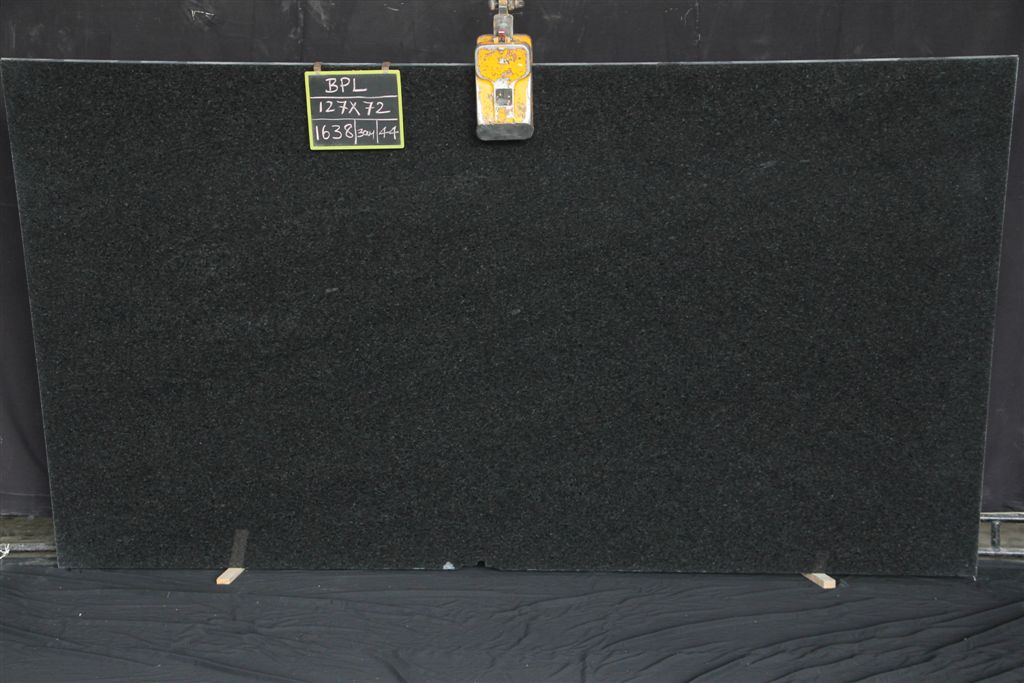
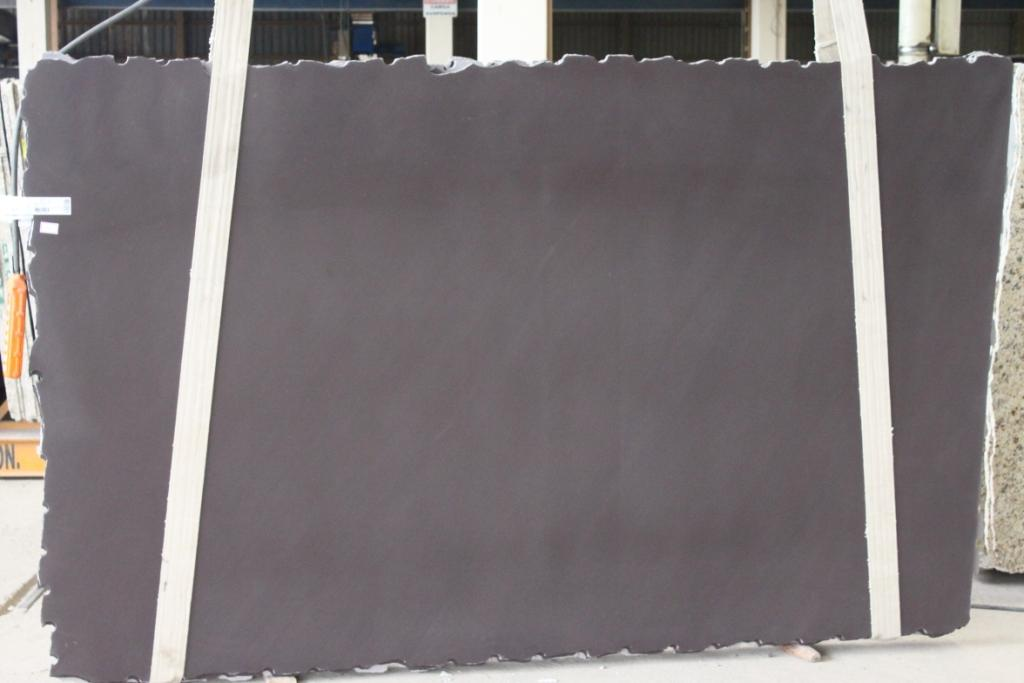
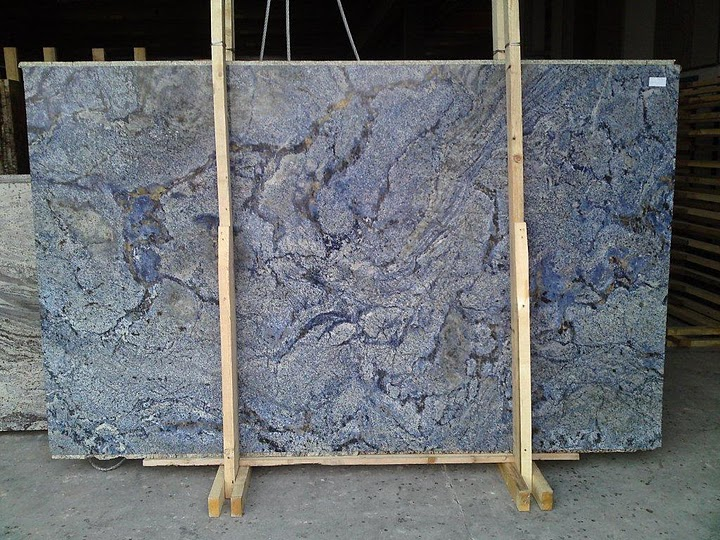
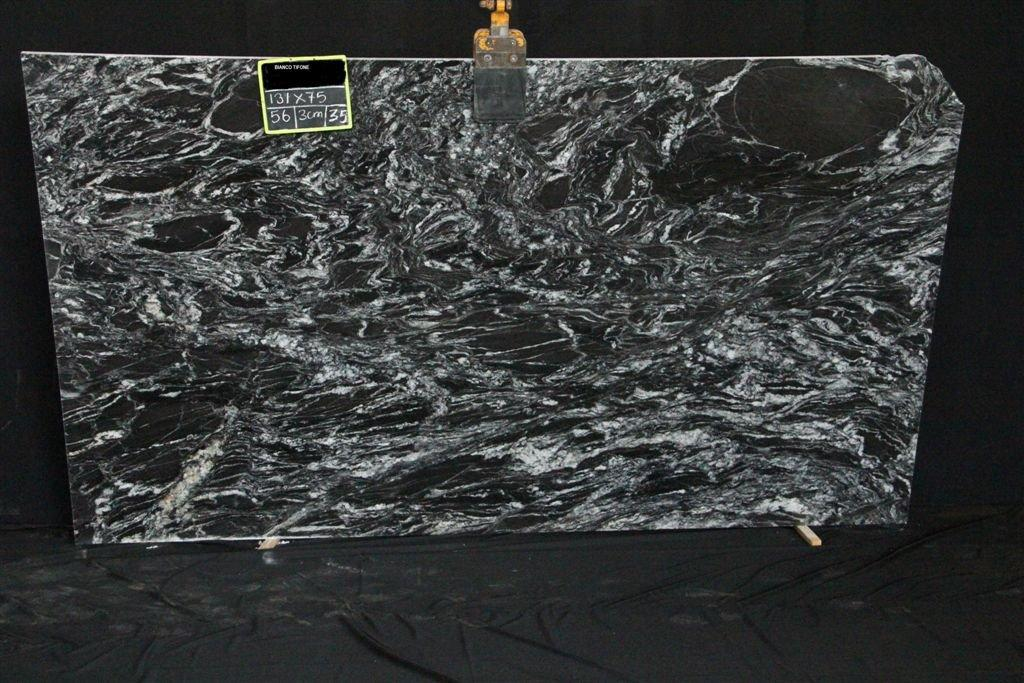

In [ ]:
import base64

def get_base64_encoded_image(image_path):
    """Encode image file to base64 string."""
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def upload_and_compare_with_thank_you(inventory_features):
    uploaded = files.upload()
    query_image_path = next(iter(uploaded))
    query_image_labels = extract_labels(query_image_path)

    # Encode the uploaded query image for display
    query_encoded_image = get_base64_encoded_image(query_image_path)

    similarities = []
    for filename, labels in inventory_features:
        similarity = compare_images(labels, query_image_labels)
        similarities.append((filename, similarity))

    top_matches = sorted(similarities, key=lambda x: x[1], reverse=True)[:3]

    html_str = "<h3>Compare your uploaded image with the top 3 similar slabs:</h3>"
    html_str += '<div style="display:flex; justify-content: space-around; align-items: center;">'
    html_str += f'<div style="text-align:center; padding:10px; flex: 1;">'
    html_str += f'<img src="data:image/jpeg;base64,{query_encoded_image}" style="max-width:100%; height:auto;"><br>'
    html_str += '<b>Uploaded Image</b><br>'
    html_str += '</div>'
    for filename, similarity in top_matches:
        material_name = filename.split('.')[0]
        image_path = os.path.join(inventory_directory, filename)
        encoded_image = get_base64_encoded_image(image_path)
        html_str += f'<div style="text-align:center; padding:10px; flex: 1;">'
        html_str += f'<img src="data:image/jpeg;base64,{encoded_image}" style="max-width:100%; height:auto;"><br>'
        html_str += f'<b>{material_name}</b> (Similarity: {similarity:.2f})<br>'
        html_str += f'<button onclick="document.getElementById(\'selected\').value=\'{material_name}\';document.getElementById(\'feedback\').innerHTML = \'You selected: {material_name}. Thank you!\';">Select</button></div>'
    html_str += '</div>'
    html_str += '<input type="hidden" id="selected" value="">'
    html_str += '<p id="feedback" style="color: green; font-size: 16px; font-weight: bold;"></p>'

    # Add a thank-you note and explanation below
    html_str += '''
    <h4>Thank You!</h4>
    <p>We truly appreciate your assistance in helping us improve our AI-based slab comparison system.</p>
    <p>We're working on an advanced solution to assist customers like you in finding the best slab materials that match your requirements. We know that materials can sometimes have different names across companies, which makes selecting the right one challenging. Our tool aims to find the closest matches by analyzing the appearance and characteristics of your chosen slabs.</p>
    <p>Your input will not only help you find the most suitable material but will also contribute to refining our AI system so that it can become even better at finding accurate matches in the future.</p>
    <p>Thanks again for your support!</p>
    '''

    display(HTML(html_str))

# Run the function
upload_and_compare_with_thank_you(inventory_features)


